# Test

In [2]:
!pwd

/Users/kaikailiu/Documents/MyRepo/DeepDataMiningLearning/DeepDataMiningLearning


In [3]:
from PIL import Image
# Read the image file from disk and resize it
image = Image.open("../sampledata/sjsuimag1.jpg")
width, height = 256, 256
image = image.resize((width, height))

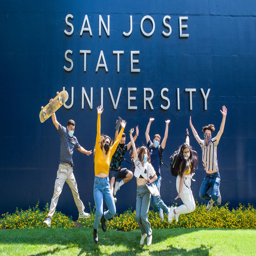

In [4]:
image

In [9]:
import numpy as np
#convert PIL image to numpy
a = np.asarray(image)
a.shape #HWC format (height, width, color channels)

(256, 256, 3)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'test image')

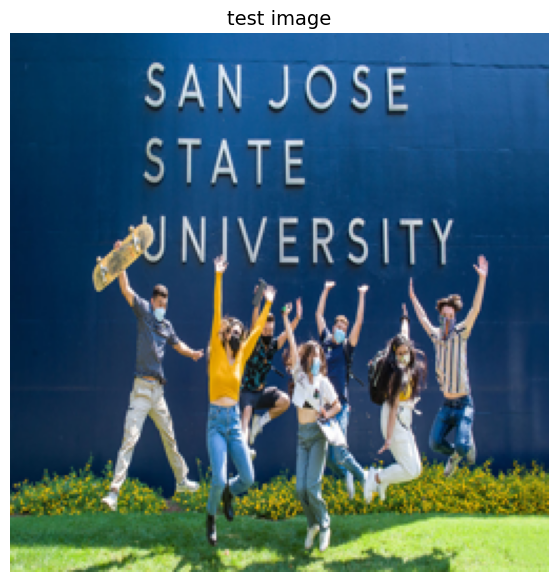

In [12]:
# Plot the image, matplotlib also uses HWC format
plt.figure(figsize=(10, 7))
plt.imshow(a)
plt.axis("off")
plt.title("test image", fontsize=14)

In [5]:
import torch
from torchvision.transforms import v2

/Users/kaikailiu/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/kaikailiu/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Pl

https://pytorch.org/vision/stable/transforms.html

In [8]:
#Tensor image are expected to be of shape (C, H, W)
transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

AttributeError: module 'torchvision.transforms.v2' has no attribute 'ToImage'

In [7]:
img = transforms(image)

TypeError: Normalize() does not support PIL images.

# Test Models

In [13]:
import torch
from torch import nn

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
a.shape #HWC format (height, width, color channels) HWC

(256, 256, 3)

In [32]:
inp = a.transpose((2,0,1)) #HWC -> CHW
inp.shape

(3, 256, 256)

In [33]:
inp = inp/255

In [34]:
inp = torch.from_numpy(inp)

In [35]:
inp=inp.unsqueeze(dim=0).float()
inp.shape

torch.Size([1, 3, 256, 256])

In [36]:
alex_model = AlexNet()
output = alex_model(inp)
print(output.shape)

torch.Size([1, 1000])


In [37]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        relu = nn.ReLU()
        self.branch1 = nn.Sequential(
                  nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                  relu)

        conv3_1 = nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        conv3_3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.branch2 = nn.Sequential(conv3_1, conv3_3,relu)

        conv5_1 = nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        conv5_5 = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2)
        self.branch3 = nn.Sequential(conv5_1,conv5_5,relu)

        max_pool_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        conv_max_1 = nn.Conv2d(in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.branch4 = nn.Sequential(max_pool_1, conv_max_1,relu)

    def forward(self, input):
        output1 = self.branch1(input)
        output2 = self.branch2(input)
        output3 = self.branch3(input)
        output4 = self.branch4(input)
        return torch.cat([output1, output2, output3, output4], dim=1)


In [38]:
inception_model = InceptionModule(in_channels=3,out_channels=32)
output = inception_model(inp)
print(output.shape)

torch.Size([1, 128, 256, 256])


In [39]:
import torchvision

model = torchvision.models.DenseNet(
    growth_rate = 16, # how many filters to add each layer (`k` in paper)
    block_config = (6, 12, 24, 16), # how many layers in each pooling block
    num_init_features = 16, # the number of filters to learn in the first convolution layer (k0)
    bn_size= 4, # multiplicative factor for number of bottleneck (1x1 cons) layers
    drop_rate = 0, # dropout rate after each dense conv layer
    num_classes = 30 # number of classification classes
)

print(model) # see snapshot below

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

# Hymenoptera Dataset

In [6]:
Datafolder='E:\Dataset\hymenoptera_data\hymenoptera_data'

In [8]:
!dir $Datafolder

 Volume in drive E is New Volume
 Volume Serial Number is 880A-0657

 Directory of E:\Dataset\hymenoptera_data\hymenoptera_data

03/20/2023  12:15 PM    <DIR>          .
03/20/2023  12:15 PM    <DIR>          ..
03/20/2023  12:15 PM    <DIR>          train
03/20/2023  12:15 PM    <DIR>          val
               0 File(s)              0 bytes
               4 Dir(s)  8,857,889,558,528 bytes free


In [10]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = Datafolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

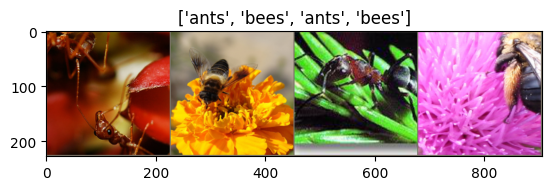

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\lkk68\.conda\envs\mycondapy39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lkk68\.conda\envs\mycondapy39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\lkk68/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
52.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_m

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7082 Acc: 0.6311
val Loss: 0.2502 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4427 Acc: 0.8033
val Loss: 0.1631 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5499 Acc: 0.7623
val Loss: 0.3430 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4895 Acc: 0.8156
val Loss: 0.1867 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4482 Acc: 0.8033
val Loss: 0.2325 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4310 Acc: 0.8238
val Loss: 0.2552 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4635 Acc: 0.8074
val Loss: 0.2855 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3125 Acc: 0.8689
val Loss: 0.2089 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3437 Acc: 0.8402
val Loss: 0.1863 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3740 Acc: 0.8197
val Loss: 0.2090 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2414 Acc: 0.9139
val Loss: 0.1946 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2557 Acc: 0.8975
val Loss: 0.1881 Acc: 0.9412

Ep

visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5499 Acc: 0.6926
val Loss: 0.2418 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5454 Acc: 0.7500
val Loss: 0.3788 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.3762 Acc: 0.8279
val Loss: 0.1883 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3949 Acc: 0.8279
val Loss: 0.1978 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4243 Acc: 0.7992
val Loss: 0.2193 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3858 Acc: 0.8238
val Loss: 0.1789 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3763 Acc: 0.8402
val Loss: 0.1890 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3647 Acc: 0.8443
val Loss: 0.1942 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3572 Acc: 0.8566
val Loss: 0.1816 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3318 Acc: 0.8443
val Loss: 0.2144 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3645 Acc: 0.8525
val Loss: 0.2207 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3345 Acc: 0.8443
val Loss: 0.1910 Acc: 0.9281

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()